In [12]:
import pyvisa
import re
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
plt.style.use('./nikhils_plot_style.mplstyle')

In [13]:
rm = pyvisa.ResourceManager()

print(rm.list_resources())

# scope = rm.open_resource('USB0::0x2A8D::0x038B::CN60150271::INSTR') # Keysight
scope = rm.open_resource('USB0::0x1AB1::0x0610::HDO1A244200510::INSTR') # Rigol

print(scope.query('*IDN?'))

('USB0::0x1AB1::0x0610::HDO1A244200510::INSTR',)
RIGOL TECHNOLOGIES,DHO1102,HDO1A244200510,00.02.00



# Acquire from Keysight

In [ ]:
################ Measurement setup ################
num_acquisitions = 25
time_per_div = 20e-3 # s
volt_per_div = 10e-3 # V
TOTAL_TIME_DIVS = 10
TOTAL_VOLT_DIVS = 8
scope.write(':CHANnel1:PROBe 1.0') # probe attenuation factor is 1:1
scope.write(f':TIMebase:RANGe {time_per_div*TOTAL_TIME_DIVS}') # 1000ms total acquisition time
scope.write(f':CHANnel1:RANGe {volt_per_div*TOTAL_VOLT_DIVS}') # 400mV full scale
scope.write(':CHANnel1:COUPling AC')

################ Trigger setup ################
scope.write(':STOP')

# scope.write(':TRIGger:FORCe') # force trigger if no trigger is detected

################ Data acquisition ###############
data_list = []
scope.write(':WAVeform:SOURce CHANnel1')
scope.write(':WAVeform:FORMat ASCII')
scope.write(':WAVeform:POINts:MODE NORmal')
scope.write(':WAVeform:POINts:MODE MAXimum')

for i in range(num_acquisitions):
    scope.write(':SINGLE')
    scope.write(':TRIGger:FORCe')
    _ = scope.query(':WAVeform:POINts?') #IMPORTANT!!! DO NOT REMOVE THIS LINE
    data = scope.query(':WAVeform:DATA?')
    data_list.append(data)
    print(f"acquisition {i+1} complete")

################ Data processing ################
for i, data in enumerate(data_list):
    data_list[i] = re.sub(r'\#\d+', '', data)
    data_list[i] = np.asarray([float(x) for x in data_list[i].split(',')])
    # print(f"number of points in the waveform: {len(data_list[i])}")
time = np.linspace(0, time_per_div*TOTAL_TIME_DIVS, len(data_list[0]))

################ Plotting ################
fig, ax = plt.subplots(figsize=(10,5))
for i in range(1):
    ax.plot(time,data_list[i], label=f'acquisition {i+1}')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.legend()
plt.show()

############### save data ################
np.savetxt('./data/johnson_data/1KOhm_cross_gain5000_100kpoints.csv', 
           np.concatenate((time.reshape(-1,1), np.transpose(data_list)), axis=-1), 
           delimiter=',')

# Acquire from Rigol

100000

99998
acquisition 1 complete
99998
acquisition 2 complete
99998
acquisition 3 complete
99998
acquisition 4 complete
99998
acquisition 5 complete
99998
acquisition 6 complete
99998
acquisition 7 complete
99998
acquisition 8 complete
99998
acquisition 9 complete
99998
acquisition 10 complete
99998
acquisition 11 complete
99998
acquisition 12 complete
99998
acquisition 13 complete
99998
acquisition 14 complete
99998
acquisition 15 complete
99998
acquisition 16 complete
99998
acquisition 17 complete
99998
acquisition 18 complete
99998
acquisition 19 complete
99998
acquisition 20 complete
99998
acquisition 21 complete
99998
acquisition 22 complete
99998
acquisition 23 complete
99998
acquisition 24 complete
99998
acquisition 25 complete
99998
acquisition 26 complete
99998
acquisition 27 complete
99998
acquisition 28 complete
99998
acquisition 29 complete
99998
acquisition 30 complete
99998
acquisition 31 complete
99998
acquisition 32 complete
99998
acquisition 33 complete
99998
acqui

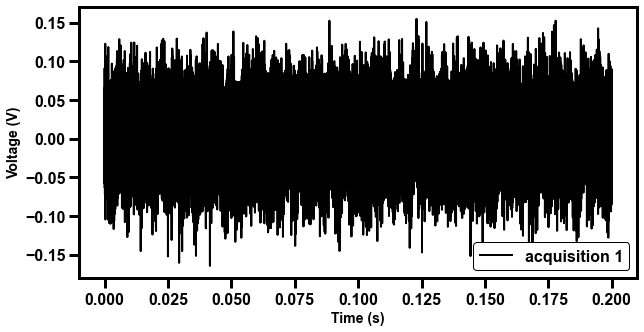

In [10]:
################ Measurement setup ################
num_acquisitions = 100
time_per_div = 20e-3 # s
volt_per_div = 100e-3 # V
TOTAL_TIME_DIVS = 10
TOTAL_VOLT_DIVS = 8
scope.write(':CHANnel1:PROBe 1') # probe attenuation factor is 1:1
scope.write(f':TIMebase:MAIN:SCALe {time_per_div}') # 1000ms total acquisition time
scope.write(f':CHANnel1:SCALe {volt_per_div}')
scope.write(':CHANnel1:COUPling AC')

# ################ Trigger setup ################
scope.write(':STOP')

# # scope.write(':TRIGger:FORCe') # force trigger if no trigger is detected

# ################ Data acquisition ###############
data_list = []
scope.write(':WAVeform:SOURce CHANnel1')
scope.write(':WAVeform:FORMat ASCII')
scope.write(':WAVeform:MODE MAX')
print(scope.query(':WAVeform:POINts?'))

for i in range(num_acquisitions):
    scope.write(':RUN')
    sleep(1)
    scope.write(':STOP')
    scope.write('WAV:STAR 1')
    # stop_points = scope.query('WAV:POIN?')
    # scope.write(f'WAV:STOP {stop_points}')
    scope.write('WAV:STOP 100000')
    data = scope.query('WAV:DATA?')
    print(len(data.split(',')))
    data_list.append(data)
    print(f"acquisition {i+1} complete")

################ Data processing ################
for i, data in enumerate(data_list):
    # data_list[i] = np.asarray([float(x) for x in data_list[i].split(',')])
    data_list[i] = np.asarray(re.findall(r'(-?\d+\.\d+e-\d+),?', data), dtype=float)
    # print(f"number of points in the waveform: {len(data_list[i])}")
time = np.linspace(0, time_per_div*TOTAL_TIME_DIVS, len(data_list[0]))

################ Plotting ################
fig, ax = plt.subplots(figsize=(10,5))
for i in range(1):
    ax.plot(time,data_list[i], label=f'acquisition {i+1}')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.legend()
plt.show()

############### save data ################
np.savetxt('./data/johnson_data/1kOhm_100avg_100kpoints_gain5000_normal.csv', 
           np.concatenate((time.reshape(-1,1), np.transpose(data_list)), axis=-1), 
           delimiter=',')

# Dual channel measurement

In [11]:
## set scope params
num_acquisitions = 100
time_per_div = 20e-3 # s
volt_per_div = 100e-3 # V
TOTAL_TIME_DIVS = 10
TOTAL_VOLT_DIVS = 8
for channel in range(1,3):
    scope.write(f':CHANnel{channel}:PROBe 1') # probe attenuation factor is 1:1
    scope.write(f':CHANnel{channel}:SCALe {volt_per_div}')
    scope.write(f':CHANnel{channel}:COUPling AC')
scope.write(f':TIMebase:MAIN:SCALe {time_per_div}') # 1000ms total acquisition time

27

99998
acquisition 1 for channel 1 complete
99998
acquisition 1 for channel 2 complete
99998
acquisition 2 for channel 1 complete
99998
acquisition 2 for channel 2 complete
99998
acquisition 3 for channel 1 complete
99998
acquisition 3 for channel 2 complete
99998
acquisition 4 for channel 1 complete
99998
acquisition 4 for channel 2 complete
99998
acquisition 5 for channel 1 complete
99998
acquisition 5 for channel 2 complete
99998
acquisition 6 for channel 1 complete
99998
acquisition 6 for channel 2 complete
99998
acquisition 7 for channel 1 complete
99998
acquisition 7 for channel 2 complete
99998
acquisition 8 for channel 1 complete
99998
acquisition 8 for channel 2 complete
99998
acquisition 9 for channel 1 complete
99998
acquisition 9 for channel 2 complete
99998
acquisition 10 for channel 1 complete
99998
acquisition 10 for channel 2 complete
99998
acquisition 11 for channel 1 complete
99998
acquisition 11 for channel 2 complete
99998
acquisition 12 for channel 1 complete
99998


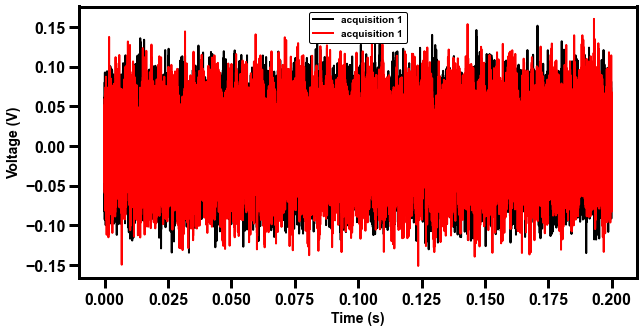

In [15]:
################ Measurement setup ################
num_acquisitions = 100
time_per_div = 20e-3 # s
volt_per_div = 100e-3 # V
TOTAL_TIME_DIVS = 10
TOTAL_VOLT_DIVS = 8
for channel in range(1,3):
    scope.write(f':CHANnel{channel}:PROBe 1') # probe attenuation factor is 1:1
    scope.write(f':CHANnel{channel}:SCALe {volt_per_div}')
    scope.write(f':CHANnel{channel}:COUPling AC')
scope.write(f':TIMebase:MAIN:SCALe {time_per_div}') # 1000ms total acquisition time

# ################ Data acquisition ###############
data_list_ch1 = []
data_list_ch2 = []

for i in range(num_acquisitions):
    scope.write(':RUN')
    sleep(1)
    scope.write(':STOP')
    for ch in range(1,3):
        scope.write(f':WAVeform:SOURce CHANnel{ch}')
        scope.write(':WAVeform:FORMat ASCII')
        scope.write(':WAVeform:MODE MAX')
        scope.write('WAV:STAR 1')
        # stop_points = scope.query('WAV:POIN?')
        # scope.write(f'WAV:STOP {stop_points}')
        scope.write('WAV:STOP 100000')
        data = scope.query('WAV:DATA?')
        print(len(data.split(',')))
        if ch == 1:
            data_list_ch1.append(data)
        else:
            data_list_ch2.append(data)
        print(f"acquisition {i+1} for channel {ch} complete")

################ Data processing ################
for i, data in enumerate(data_list_ch1):
    # data_list[i] = np.asarray([float(x) for x in data_list[i].split(',')])
    data_list_ch1[i] = np.asarray(re.findall(r'(-?\d+\.\d+e-\d+),?', data), dtype=float)
    # print(f"number of points in the waveform: {len(data_list[i])}")
for i, data in enumerate(data_list_ch2):
    # data_list[i] = np.asarray([float(x) for x in data_list[i].split(',')])
    data_list_ch2[i] = np.asarray(re.findall(r'(-?\d+\.\d+e-\d+),?', data), dtype=float)
    # print(f"number of points in the waveform: {len(data_list[i])}")
time = np.linspace(0, time_per_div*TOTAL_TIME_DIVS, len(data_list_ch1[0]))

################ Plotting ################
fig, ax = plt.subplots(figsize=(10,5))
for i in range(1):
    ax.plot(time,data_list_ch1[i], label=f'acquisition {i+1}')
    ax.plot(time,data_list_ch2[i], label=f'acquisition {i+1}')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.legend()
plt.show()

############### save data ################
np.savetxt('./data/johnson_data/1KOhm_ch1_100avg_01032024.csv', 
           np.concatenate((time.reshape(-1,1), np.transpose(data_list_ch1)), axis=-1), 
           delimiter=',')
np.savetxt('./data/johnson_data/1KOhm_ch2_100avg_01032024.csv', 
           np.concatenate((time.reshape(-1,1), np.transpose(data_list_ch2)), axis=-1), 
           delimiter=',')